## Import neccesary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow import keras
from keras import layers
import keras.backend as K

## Import dataset

In [2]:
df = pd.read_csv('data/task1.csv', index_col='index')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20401 entries, 8909 to 11748
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   browser   20401 non-null  object
 1   os        20401 non-null  object
 2   locale    20401 non-null  object
 3   user_id   20401 non-null  int64 
 4   location  20401 non-null  object
 5   sites     20401 non-null  object
 6   time      20401 non-null  object
 7   date      20401 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.4+ MB


## Apply some preprocessing

In [4]:
def add_new_features(df):
    if 'user_id' in df.columns:
        df['is_waldo'] = (df['user_id'] == 0).astype(np.int64)
    
    df['locale'] = df['locale'].replace({'ru_RU': 'ru-RU'})
    
    time = df['time'].str.split(':', expand=True).astype(np.int64)
    df['time_sec'] = (time[0] * 60 * 60 + time[1] * 60 + time[2]) / 86400
    
    return df

In [5]:
def preprocess_os(df, drop_last=False):
    """ prerocession of 'os' column
        we have ['Windows 10', 'Windows 8', 'MacOS', 'Ubuntu', 'Debian', 'Windows 7']
        let's convert to to ['Windows', 'Linux', 'MacOS']
        'Windows' - 'Windows 10', 'Windows 8', 'Windows 7'
        'Linux' - 'Ubuntu', 'Debian'
        'MacOS' - 'MacOS'
    """
    
    windows_l = ['Windows 10', 'Windows 8', 'Windows 7', 'Windows 11']
    linux_l = ['Ubuntu', 'Debian']
    macos_l = ['MacOS']
    df['is_windows'] = (df['os'].isin(windows_l) == True).astype(np.int64)
    df['is_linux'] = (df['os'].isin(linux_l) == True).astype(np.int64)
    if not drop_last:
        df['is_mac_os'] = (df['os'].isin(macos_l) == True).astype(np.int64)
    
    df = df.drop(['os'], axis=1)
    return df

In [6]:
def preprocess_browser(df, encoder, fit):
    if fit:
        encoder.fit(df[['browser']])
        
    browser_encoded = pd.DataFrame(
        encoder.transform(df[['browser']]),
        columns=encoder.get_feature_names_out(['browser']),
        index=df[['browser']].index
    )
    df = pd.concat([df, browser_encoded], axis=1)
    df = df.drop(['browser'], axis=1)
    return df

In [7]:
def remove_unnecessary_cols(df, war=True):
    """
        unnecessary columns are:
            user_id - do not need it anymore (create is_waldo)
            sites - remove for now. TODO: try to extract to info from it in future
            time - do not need it anymore (create time_sec)
            date - remove for now.
            locale - remove for now
    """
    
    if 'user_id' in df.columns:
        if 'is_waldo' not in df.columns and war:
            raise ValueError('trying to remove "user_id" without creating "is_waldo"')
        df = df.drop(['user_id'], axis=1)

    if 'time' in df.columns:
        if 'time_sec' not in df.columns and war:
            raise ValueError('trying to remove "time" without creating "time_sec"')
        df = df.drop(['time'], axis=1)
        
    if 'sites' in df.columns:
        df = df.drop(['sites'], axis=1)
        
    if 'date' in df.columns:
        df = df.drop(['date'], axis=1)
        
    if 'locale' in df.columns:
        df = df.drop(['locale'], axis=1)

    return df

In [8]:
def preprocess_location(df, encoder, fit):
    df['city'] = df['location'].str.split('/', expand=True)[1]

    if fit:
        encoder.fit(df[['city']])
        
    city_encoded = pd.DataFrame(
        encoder.transform(df[['city']]),
        columns=encoder.get_feature_names_out(['city']),
        index=df[['city']].index
    )
    df = pd.concat([df, city_encoded], axis=1)
    
    df = df.drop(['city'], axis=1)
    df = df.drop(['location'], axis=1)
    return df

In [9]:
location_encoder = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False)
browser_encoder = OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False)

In [10]:
df = add_new_features(df)
df = preprocess_os(df)
df = preprocess_browser(df, browser_encoder, fit=True)
df = preprocess_location(df, location_encoder, fit=True)
df = remove_unnecessary_cols(df)

In [11]:
df.head()

,is_waldo,time_sec,is_windows,is_linux,is_mac_os,browser_Chrome,browser_Firefox,browser_Internet Explorer,browser_Safari,city_Amsterdam,...,city_Paris,city_Rio de Janeiro,city_Rome,city_San Francisco,city_Shanghai,city_Singapore,city_Sydney,city_Tokyo,city_Toronto,city_Vancouver
index,,,,,,,,,,,,,,,,,,,,,
8909,0,0.593056,1,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
17679,0,0.224306,1,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11803,0,0.502083,0,0,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
356,0,0.255556,0,1,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10948,0,0.165972,1,0,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


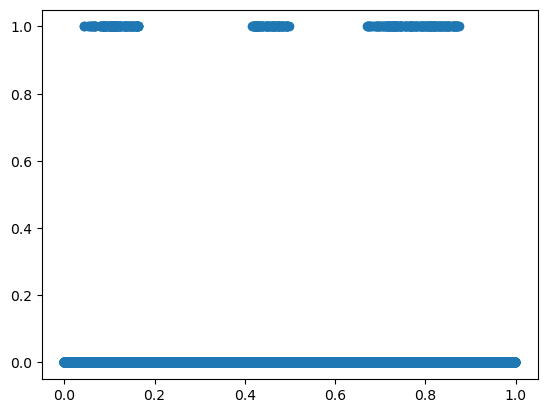

In [12]:
plt.scatter(df['time_sec'], df['is_waldo'])

## Train Test Split

In [13]:
X = df.drop(['is_waldo'], axis=1)
y = df['is_waldo']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [14]:
print(X_train.shape)
features = X_train.shape[1]
classes = 1

(16320, 29)


## Keras Model

In [15]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(features,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(classes, activation='sigmoid')
])

2023-04-15 23:30:05.100653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-04-15 23:30:05.100722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: sadi
2023-04-15 23:30:05.100823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: sadi
2023-04-15 23:30:05.100996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 390.157.0
2023-04-15 23:30:05.101041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 390.157.0
2023-04-15 23:30:05.101054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 390.157.0


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3840      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 1)                 9

## Custom metric (f1_score)

In [17]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score


## Model

In [18]:
learning_rate = 0.001
epochs = 200
batch_size = 128


loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
metrics = [f1_score, 'AUC', 'accuracy']

In [19]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics
)

## Fit the Model

In [20]:
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    verbose=0
)

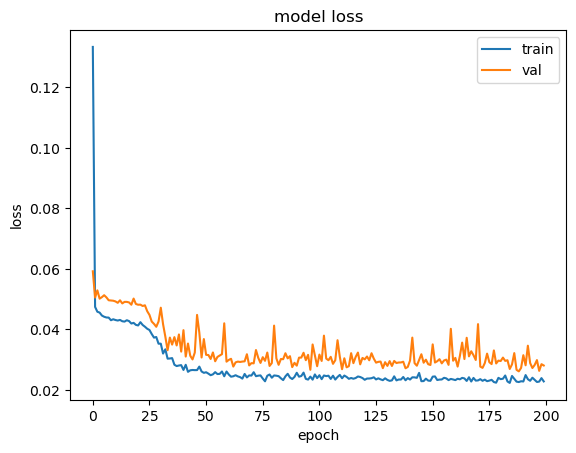

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

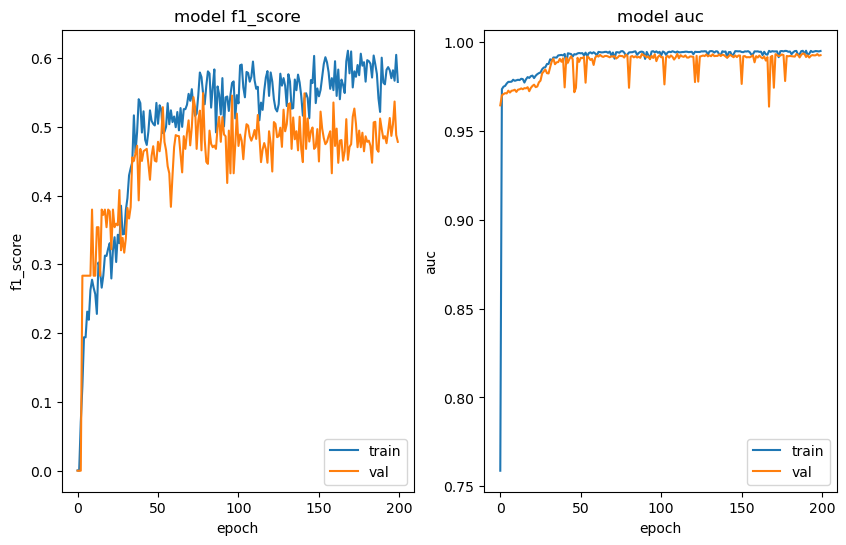

In [22]:
def plot_metric(metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history[f'val_{metric_name}'])
    plt.title(f'model {metric_name}')
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plot_metric('f1_score')

plt.subplot(1, 2, 2)
plot_metric('auc')

### Evaluate test set

In [23]:
model.evaluate(X_test, y_test)

128/128 [==============================] - 0s 3ms/step - loss: 0.0315 - f1_score: 0.2859 - auc: 0.9927 - accuracy: 0.9855


[0.03150152787566185,
 0.28593745827674866,
 0.9926736950874329,
 0.9855427742004395]

In [24]:
y_pred = (model.predict(X_test) >= 0.5).astype(np.int64)

print(classification_report(y_test, y_pred))

128/128 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4001
           1       0.63      0.62      0.63        80

    accuracy                           0.99      4081
   macro avg       0.81      0.81      0.81      4081
weighted avg       0.99      0.99      0.99      4081



## Predict new data

In [25]:
df_test = pd.read_csv('data/task_1_verify.csv')

df_test = add_new_features(df_test)
df_test = preprocess_os(df_test)
df_test = preprocess_browser(df_test, browser_encoder, fit=False)
df_test = preprocess_location(df_test, location_encoder, fit=False)
df_test = remove_unnecessary_cols(df_test)

In [26]:
submission = pd.DataFrame(
    (model.predict(df_test) >= 0.5).astype(np.int64),
    columns=['is_waldo'],
    index=df_test.index
)

submission.to_csv('data/task1_predictions.csv')

2/2 [==============================] - 0s 6ms/step


In [27]:
submission

,is_waldo
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Save the model


In [28]:
model.save('models/task1_simple_ann_v1')

INFO:tensorflow:Assets written to: models/task1_simple_ann_v1/assets


INFO:tensorflow:Assets written to: models/task1_simple_ann_v1/assets
